# <center> <span style="color:red">Music recognition </span> </center>

The purpose of this notebook is to take in music spectrograms and to recognize musical genres

## Import 

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, accuracy_score
from IPython.display import clear_output
from eli5.sklearn import PermutationImportance
import eli5

In [2]:
target_size = (8, 8)

## Import Model Linear and MLP 

In [3]:
import sys  
sys.path.insert(0, '../../python')

from linearModel import linearModel
from mlp import MLPModel
from wrapper import MyMLPRawWrapper

## Create Model 

In [4]:
lm = linearModel()
mlp = MLPModel()

## Algorithme 

In [5]:
def import_images_and_assign_labels(folder, label, X, Y):
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        im = Image.open(image_path)
        im = im.resize((8, 8))
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (8 * 8 * 3))
        X.append(im_arr)
        Y.append(label)

In [6]:
def import_dataset():
    dataset_folder = "../../data/"
    train_folder = os.path.join(dataset_folder, "train")
    test_folder = os.path.join(dataset_folder, "test")

    X_train = []
    y_train = []
    
    import_images_and_assign_labels(
        os.path.join(train_folder, "Electro"), [1,0,0], X_train, y_train
    )
    import_images_and_assign_labels(
        os.path.join(train_folder, "Metal"), [0,1,0], X_train, y_train
    )
    
    import_images_and_assign_labels(
        os.path.join(train_folder, "Rap"), [0,0,1], X_train, y_train
    )
    
    X_test = []
    y_test = []
    import_images_and_assign_labels(
        os.path.join(test_folder, "Electro"), [1,0,0], X_test, y_test
    )
    import_images_and_assign_labels(
        os.path.join(test_folder, "Metal"), [0,1,0], X_test, y_test
    )
    
    import_images_and_assign_labels(
        os.path.join(test_folder, "Rap"), [0,0,1], X_test, y_test
    )
    
    return (np.array(X_train) / 255.0, np.array(y_train)), \
           (np.array(X_test) / 255.0, np.array(y_test))

In [7]:
def display_value(array):
    print("Sur le dataset de Train")
    cpt = 0
    number = len(array)/3
    for i in array:
        print(cpt," ",np.argmax(i )," ",i)
        cpt+=1
        if(cpt==number):
            cpt=0

In [22]:
def percentage_music_style(array):
    item1 = 0
    item2 = 0
    item3 = 0
    itemGlobal = 0 
    cpt = 0
    for i in array:
        if cpt<50:
            if np.argmax(i) == 0:
                item2 += 2
        elif cpt<100:
            if np.argmax(i) == 1: 
                item1 += 2
        else:
            if np.argmax(i) == 2:
                item3 +=2
        cpt+=1
    itemGlobal = round((item1+item2+item3)/3,2)
        
    print(f"il y a {item2}% de chanson identifié en électro")
    print(f"il y a {item1}% de chanson identifié en métal")
    print(f"il y a {item3}% de chanson identifié en rap")
    print(f"L'accuracy de notre ia est de {itemGlobal}%")

In [9]:
def my_mean_squared_error(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

In [24]:
def run_mlp_wrapper():
    (X_train, y_train), (X_test, y_test) = import_dataset()
    wrapped_model = MyMLPRawWrapper([192,32,32,3], True, 1e-2, 10000)

    losses = []
    val_losses = []
    accs = []
    val_accs = []
        
    for epoch in range(100):
        wrapped_model.fit(X_train, y_train)
        y_pred = wrapped_model.predict(X_train)
        loss = mean_squared_error(y_train, y_pred)
        losses.append(loss)
        val_y_pred = wrapped_model.predict(X_test)
        val_loss = mean_squared_error(y_test, val_y_pred)
        val_losses.append(val_loss)

        acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_pred, axis=1))
        accs.append(acc)

        val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(val_y_pred, axis=1))
        val_accs.append(val_acc)

        clear_output(True)

        plt.plot(losses)
        plt.plot(val_losses)
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.title('Evolution of loss (MSE)')
        plt.xlabel('epochs')
        plt.ylabel(f'mean squared error')
        plt.show()  

        plt.plot(accs)
        plt.plot(val_accs)
        plt.legend(['acc', 'val_acc'], loc='upper left')
        plt.title('Evolution of accuracy')
        plt.xlabel('epochs')
        plt.ylabel(f'accuracy')
        plt.show()
        
    mlp.save_mlp_classification(wrapped_model.model)

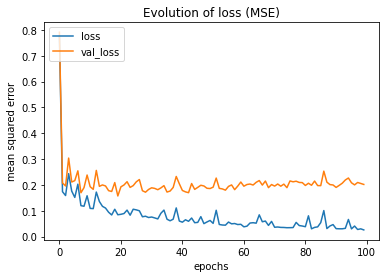

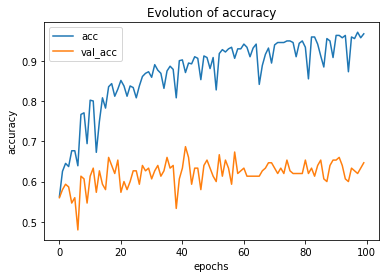

In [25]:
run_mlp_wrapper()

In [26]:
def load_mlp():
    (X_train, y_train), (X_test, y_test) = import_dataset()
    
    resultat2 = mlp.load_mlp_model("../../Save/mlp_classification_192_32_32_3_2021723122610.json")
    model2 = resultat2[0]
        
    predicted_outputs = [mlp.predict_mlp_model_classification(model2, p) for p in X_test]

    display_value(predicted_outputs)
    percentage_music_style(predicted_outputs)
    
    mlp.free_MLP(resultat2)

In [27]:
load_mlp()

Sur le dataset de Train
0   0   [0.5936679840087891, 0.19344723224639893, -0.035680755972862244]
1   1   [-0.11407874524593353, 0.9706483483314514, 0.030083337798714638]
2   2   [-0.17696240544319153, -0.002445320365950465, 0.9321388602256775]
3   0   [0.6497563123703003, -0.009687329642474651, 0.476127564907074]
4   0   [0.9069769978523254, 0.0029430901631712914, 0.13120359182357788]
5   0   [0.955311119556427, -0.013786962255835533, 0.04966336116194725]
6   2   [0.23834823071956635, 0.03503195941448212, 0.9576062560081482]
7   0   [0.9429502487182617, -0.33678480982780457, -0.4118063449859619]
8   0   [0.8246241807937622, 0.07908710092306137, 0.0635622963309288]
9   0   [0.8785538077354431, 0.1060681864619255, 0.38126057386398315]
10   0   [0.5963665843009949, 0.07343721389770508, 0.21010582149028778]
11   0   [0.6918071508407593, 0.018977539613842964, 0.5249119997024536]
12   2   [0.6618202924728394, 0.12914104759693146, 0.7466251850128174]
13   0   [0.8654367923736572, -0.380346119